### Plot Spectrogram

In [1]:
import librosa
import pywt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Figures appear in notebook inline
%matplotlib inline


### Functions

In [2]:
def plot_spectrogram(y, ylim):
    """Plot the linear-frequency power spectrogram"""

    D = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, window='hann')  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)    # STFT in dB
    print(S_db.shape)
    
    # Plot
    librosa.display.specshow(S_db, sr=SR, hop_length=HOP_LENGTH, x_axis='s', y_axis='linear')
    plt.colorbar(format="%+2.f dB")
    plt.title('Linear-frequency Power Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(ylim)


def plot_cwt(y, sr, scales, wavelet):
    """Plot the wavelet scalogram"""

    # Compute continuous wavelet transform
    wavelet_coeffs, wavelet_freqs = apply_cwt(y, sr, scales, wavelet)
    cwt = librosa.amplitude_to_db(np.abs(wavelet_coeffs), ref=np.max)    # Take log

    # Pad cwt to match STFT etc.
    size = cwt.shape[1] + (FRAME_LENGTH//2)*2
    cwt_padded = librosa.util.pad_center(cwt, size=size, axis=1)
   
    # Split coefficients into frames along sample axis
    cwt_framed = librosa.util.frame(cwt_padded, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, axis=1)

    # Average coeffs for each frome
    cwt_avg = np.mean(cwt_framed, axis=2)
    
    # Compute time array
    time = np.linspace(0, len(y)/sr, num=cwt_avg.shape[1])

    # Plot the wavelet scalogram.
    plt.pcolormesh(time, wavelet_freqs, cwt_avg, cmap='magma')
    plt.colorbar(format="%+2.f dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Pseudo-frequency (Hz)")
    plt.title("Wavelet Scalogram")


def apply_cwt(y, sr, scales, wavelet):
    """Apply cwt to a 1D array"""
    
    # Compute continuous wavelet transform
    wavelet_coeffs, wavelet_freqs = pywt.cwt(y, scales, wavelet, sampling_period=1/sr)

    return wavelet_coeffs, wavelet_freqs
    

def scale2frequency(wavelet, scales, sr):
    """Convert from cwt scale to to pseudo-frequency"""

    # pywt function returns normalised frequency so need to multiply by sr
    freqs = pywt.scale2frequency(wavelet, scales) * sr

    return freqs


def frequency2scale(wavelet, desired_freqs, sr):
    """Convert from desired frequencies to a cwt scale"""

    # pywt function input is normalised frequency so need to normalise by sr
    normalised_freqs = desired_freqs / sr
    
    freqs = pywt.scale2frequency(wavelet, normalised_freqs)

    return freqs


def plot_wavelet(wavelet):   
    """Plot wavelet"""

    wav = pywt.ContinuousWavelet(wavelet)

    name = wav.family_name[:-1]

    print(f'{name}\n' + '-'*30 + f'\nCenter frequency: {wav.center_frequency}\n'
      f'Bandwidth frequency: {wav.bandwidth_frequency}\n')

    [psi, x] = wav.wavefun(level=8)

    plt.figure()
    plt.plot(x, np.real(psi))
    plt.title(f'{name} (Real Part)')
    plt.xlabel('Number of samples analysed at scale=1')
    plt.ylabel('Magnitude')

    return psi, x


def plot_dft(y, sr, title='DFT Magnitude', xlabel='Frequency (Hz)', ylabel='Magnitude'):
    """Plot DFT magnitude for a real 1D array"""

    # Calculate DFT
    y_dft = np.fft.rfft(y)

    # Calculate DFT frequency bins
    dft_freqs = np.fft.rfftfreq(y.size, d=1/sr)

    # Plot
    plt.figure()
    plt.plot(dft_freqs, np.abs(y_dft))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.xlim([10,40])
    

### Constants

In [3]:
SR = 250                  # sample rate Hz
FRAME_DURATION = 1000    #  window duration in ms
FRAME_OVERLAP = 75           # window overlap %


In [4]:
# CALCULATED CONSTANTS (DO NOT CHANGE)
#------------------------------------------------------------------------------
FRAME_LENGTH = round(SR * FRAME_DURATION / 1000)    # frame length (samples)
HOP_LENGTH = round(FRAME_LENGTH *(100-FRAME_OVERLAP)/100) # hoplength (samples)
N_FFT = FRAME_LENGTH*2
WIN_LENGTH = FRAME_LENGTH


### View call log

In [5]:
# File path to log file
log_filepath = r"C:\Users\james\OneDrive - Nexus365\Engineering\Year4\4YP\git\marine_acoustics\data\AcousticTrends_BlueFinLibrary\BallenyIslands2015\Balleny2015.BmAnt-A.selections.txt"
log_filename = log_filepath.split('\\')[-1]
print(f'Loaded file: {log_filename}\n')

fields = ['Begin File', 'End File','Begin Time (s)', 'End Time (s)',
              'Beg File Samp (samples)', 'End File Samp (samples)',
              'Begin Date Time', 'Delta Time (s)', 'Low Freq (Hz)',
              'High Freq (Hz)', 'Dur 90% (s)', 'Freq 5% (Hz)', 'Freq 95% (Hz)']

    
df_log = pd.read_csv(log_filepath, sep='\t', usecols=fields)

gb_wavfile = df_log.groupby('Begin File')


for wav, logs in gb_wavfile:
    display(logs)


Loaded file: Balleny2015.BmAnt-A.selections.txt



,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
0,20150204_030000.wav,20150204_030000.wav,41197.053,41208.709,1652038,1663694,2015/2/4 3:27:32.053,11.656,21.9,28.4,10.2,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
1,20150216_110000.wav,20150216_110000.wav,67995.436,68001.414,3250408,3256386,2015/2/16 11:54:10.436,5.978,22.4,27.3,5.2,22.5,26.4
2,20150216_110000.wav,20150216_110000.wav,67889.753,67894.236,3144725,3149208,2015/2/16 11:52:24.753,4.483,24.5,27.3,3.7,25.4,26.4
3,20150216_110000.wav,20150216_110000.wav,67792.251,67798.004,3047223,3052976,2015/2/16 11:50:47.251,5.753,24.2,27.6,4.8,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
4,20150220_000000.wav,20150220_000000.wav,74261.379,74269.225,2316347,2324193,2015/2/20 0:38:36.379,7.846,22.7,27.3,6.3,23.4,26.4
5,20150220_000000.wav,20150220_000000.wav,72095.028,72100.632,149996,155600,2015/2/20 0:02:29.028,5.604,23.7,26.8,4.5,24.4,26.4
6,20150220_000000.wav,20150220_000000.wav,74647.994,74655.765,2702962,2710733,2015/2/20 0:45:02.994,7.771,22.9,28.4,5.9,24.4,27.3
7,20150220_000000.wav,20150220_000000.wav,75516.582,75521.589,3571550,3576557,2015/2/20 0:59:31.582,5.007,22.9,27.3,4.2,23.4,26.4
8,20150220_000000.wav,20150220_000000.wav,72368.263,72374.689,423231,429657,2015/2/20 0:07:03.263,6.426,23.2,27.9,5.2,24.4,27.3
9,20150220_000000.wav,20150220_000000.wav,74306.883,74315.177,2361851,2370145,2015/2/20 0:39:21.883,8.294,22.9,28.4,7.2,23.4,28.3
10,20150220_000000.wav,20150220_000000.wav,72302.734,72309.011,357702,363979,2015/2/20 0:05:57.734,6.277,23.7,27.6,5.5,24.4,27.3
11,20150220_000000.wav,20150220_000000.wav,74236.124,74249.574,2291092,2304542,2015/2/20 0:38:11.124,13.450,22.7,27.3,11.7,23.4,26.4
12,20150220_000000.wav,20150220_000000.wav,72043.142,72051.585,98110,106553,2015/2/20 0:01:38.142,8.443,23.4,27.6,7.1,23.4,27.3
13,20150220_000000.wav,20150220_000000.wav,72108.253,72117.967,163221,172935,2015/2/20 0:02:43.253,9.714,23.2,28.1,8.3,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
22,20150223_130000.wav,20150223_130000.wav,80317.524,80322.231,1172489,1177196,2015/2/23 13:19:32.524,4.707,24.0,26.8,3.7,24.4,26.4
23,20150223_130000.wav,20150223_130000.wav,79803.601,79808.308,658566,663273,2015/2/23 13:10:58.601,4.707,23.4,27.6,3.9,23.4,27.3
24,20150223_130000.wav,20150223_130000.wav,79738.072,79746.665,593037,601630,2015/2/23 13:09:53.072,8.593,23.7,27.1,7.2,24.4,26.4
25,20150223_130000.wav,20150223_130000.wav,79867.890,79874.390,722855,729355,2015/2/23 13:12:02.890,6.500,24.0,27.1,5.1,24.4,26.4
26,20150223_130000.wav,20150223_130000.wav,80057.962,80065.210,912927,920175,2015/2/23 13:15:12.962,7.248,23.4,26.3,6.2,23.4,25.4
27,20150223_130000.wav,20150223_130000.wav,80688.821,80693.976,1543786,1548941,2015/2/23 13:25:43.821,5.155,23.2,27.3,4.3,23.4,26.4
28,20150223_130000.wav,20150223_130000.wav,80555.267,80561.992,1410232,1416957,2015/2/23 13:23:30.267,6.725,23.2,27.1,5.5,23.4,26.4
29,20150223_130000.wav,20150223_130000.wav,81941.035,81947.088,2796000,2802053,2015/2/23 13:46:36.035,6.053,23.4,26.8,4.5,23.4,26.4
30,20150223_130000.wav,20150223_130000.wav,79516.767,79523.641,371732,378606,2015/2/23 13:06:11.767,6.874,23.7,27.9,5.9,24.4,27.3
31,20150223_130000.wav,20150223_130000.wav,80424.328,80431.875,1279293,1286840,2015/2/23 13:21:19.328,7.547,23.7,28.1,5.2,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
40,20150225_070000.wav,20150225_070000.wav,84739.061,84747.429,2022024,2030392,2015/2/25 7:33:42.061,8.368,24.5,27.9,6.8,25.4,27.3
41,20150225_070000.wav,20150225_070000.wav,83293.106,83301.997,576069,584960,2015/2/25 7:09:36.106,8.891,22.4,28.1,6.5,22.5,27.3
42,20150225_070000.wav,20150225_070000.wav,84866.861,84874.557,2149824,2157520,2015/2/25 7:35:49.861,7.696,22.9,27.9,6.0,24.4,27.3
43,20150225_070000.wav,20150225_070000.wav,85605.078,85613.372,2888041,2896335,2015/2/25 7:48:08.078,8.294,24.0,28.4,7.1,24.4,28.3
44,20150225_070000.wav,20150225_070000.wav,85410.971,85423.150,2693934,2706113,2015/2/25 7:44:53.971,12.179,23.7,27.3,11.1,24.4,26.4
45,20150225_070000.wav,20150225_070000.wav,84220.094,84228.089,1503057,1511052,2015/2/25 7:25:03.094,7.995,23.4,27.9,6.6,23.4,27.3
46,20150225_070000.wav,20150225_070000.wav,85542.208,85550.278,2825171,2833241,2015/2/25 7:47:05.208,8.070,24.0,28.4,6.0,24.4,27.3
47,20150225_070000.wav,20150225_070000.wav,83836.543,83843.566,1119506,1126529,2015/2/25 7:18:39.543,7.023,23.4,29.2,5.9,23.4,28.3
48,20150225_070000.wav,20150225_070000.wav,84996.679,85004.824,2279642,2287787,2015/2/25 7:37:59.679,8.145,23.7,26.3,6.0,24.4,25.4
49,20150225_070000.wav,20150225_070000.wav,84346.213,84354.358,1629176,1637321,2015/2/25 7:27:09.213,8.145,23.7,26.8,6.0,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
65,20150227_010000.wav,20150227_010000.wav,89777.888,89785.435,3488849,3496396,2015/2/27 1:58:08.888,7.547,21.9,27.6,6.0,22.5,27.3
66,20150227_010000.wav,20150227_010000.wav,88609.576,88618.916,2320537,2329877,2015/2/27 1:38:40.576,9.340,22.7,28.4,8.3,23.4,28.3
67,20150227_010000.wav,20150227_010000.wav,87158.547,87163.628,869508,874589,2015/2/27 1:14:29.547,5.081,23.7,28.1,3.7,24.4,27.3
68,20150227_010000.wav,20150227_010000.wav,89072.846,89078.301,2783807,2789262,2015/2/27 1:46:23.846,5.455,24.5,27.6,4.6,25.4,27.3
69,20150227_010000.wav,20150227_010000.wav,89107.964,89116.258,2818925,2827219,2015/2/27 1:46:58.964,8.294,21.6,28.4,6.3,22.5,27.3
70,20150227_010000.wav,20150227_010000.wav,87478.512,87486.283,1189473,1197244,2015/2/27 1:19:49.512,7.771,24.0,28.6,6.3,24.4,28.3
71,20150227_010000.wav,20150227_010000.wav,87423.220,87430.991,1134181,1141952,2015/2/27 1:18:54.220,7.771,23.2,27.1,6.6,23.4,26.4
72,20150227_010000.wav,20150227_010000.wav,88673.984,88682.203,2384945,2393164,2015/2/27 1:39:44.984,8.219,23.7,28.4,6.9,24.4,28.3
73,20150227_010000.wav,20150227_010000.wav,86780.749,86787.848,491710,498809,2015/2/27 1:08:11.749,7.099,23.2,26.8,5.2,23.4,26.4
74,20150227_010000.wav,20150227_010000.wav,88971.496,88981.210,2682457,2692171,2015/2/27 1:44:42.496,9.714,24.0,27.6,7.9,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
77,20150228_200000.wav,20150228_200000.wav,90476.473,90486.859,615432,625818,2015/2/28 20:10:15.473,10.386,22.7,27.9,8.0,23.4,27.3
78,20150228_200000.wav,20150228_200000.wav,90209.066,90218.481,348025,357440,2015/2/28 20:05:48.066,9.415,22.7,28.1,8.3,23.4,27.3
79,20150228_200000.wav,20150228_200000.wav,92338.625,92349.160,2477584,2488119,2015/2/28 20:41:17.625,10.535,22.9,28.1,8.8,23.4,27.3
80,20150228_200000.wav,20150228_200000.wav,90051.048,90060.239,190007,199198,2015/2/28 20:03:10.048,9.191,23.2,27.3,7.5,23.4,26.4
81,20150228_200000.wav,20150228_200000.wav,90926.107,90937.464,1065066,1076423,2015/2/28 20:17:45.107,11.357,22.9,27.9,10.0,23.4,27.3
82,20150228_200000.wav,20150228_200000.wav,92323.681,92331.227,2462640,2470186,2015/2/28 20:41:02.681,7.546,20.3,27.3,6.3,21.5,26.4
83,20150228_200000.wav,20150228_200000.wav,90105.624,90114.665,244583,253624,2015/2/28 20:04:04.624,9.041,23.2,28.1,6.2,24.4,27.3
84,20150228_200000.wav,20150228_200000.wav,93361.614,93369.833,3500573,3508792,2015/2/28 20:58:20.614,8.219,21.9,28.6,6.6,22.5,27.3
85,20150228_200000.wav,20150228_200000.wav,93425.648,93434.390,3564607,3573349,2015/2/28 20:59:24.648,8.742,22.7,28.1,7.5,23.4,27.3
86,20150228_200000.wav,20150228_200000.wav,93013.031,93022.969,3151990,3161928,2015/2/28 20:52:31.031,9.938,22.7,28.1,8.0,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
98,20150302_140000.wav,20150302_140000.wav,93465.654,93475.965,4612,14923,2015/3/2 14:00:04.654,10.311,22.9,27.3,8.3,23.4,26.4
99,20150302_140000.wav,20150302_140000.wav,94215.533,94228.684,754491,767642,2015/3/2 14:12:34.533,13.151,22.9,28.9,11.4,23.4,28.3
100,20150302_140000.wav,20150302_140000.wav,93590.391,93600.030,129349,138988,2015/3/2 14:02:09.391,9.639,24.0,28.9,8.2,24.4,28.3
101,20150302_140000.wav,20150302_140000.wav,96579.279,96586.228,3118237,3125186,2015/3/2 14:51:58.279,6.949,23.2,28.1,5.5,23.4,27.3
102,20150302_140000.wav,20150302_140000.wav,94563.997,94578.119,1102955,1117077,2015/3/2 14:18:22.997,14.122,24.2,28.1,13.1,24.4,27.3
103,20150302_140000.wav,20150302_140000.wav,94638.193,94649.551,1177151,1188509,2015/3/2 14:19:37.193,11.358,22.7,28.9,9.5,23.4,28.3
104,20150302_140000.wav,20150302_140000.wav,95716.026,95722.527,2254984,2261485,2015/3/2 14:37:34.026,6.501,22.9,27.6,5.7,23.4,27.3
105,20150302_140000.wav,20150302_140000.wav,96327.190,96342.134,2866148,2881092,2015/3/2 14:47:46.190,14.944,23.4,27.9,13.4,23.4,27.3
106,20150302_140000.wav,20150302_140000.wav,93603.467,93614.301,142425,153259,2015/3/2 14:02:22.467,10.834,22.9,26.6,8.6,23.4,26.4
107,20150302_140000.wav,20150302_140000.wav,96645.138,96650.517,3184096,3189475,2015/3/2 14:53:04.138,5.379,23.4,27.6,3.9,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
125,20150304_080000.wav,20150304_080000.wav,97776.320,97785.585,715276,724541,2015/3/4 8:11:55.320,9.265,23.4,28.4,7.9,23.4,27.3
126,20150304_080000.wav,20150304_080000.wav,97227.952,97235.947,166908,174903,2015/3/4 8:02:46.952,7.995,23.7,27.6,5.9,24.4,27.3
127,20150304_080000.wav,20150304_080000.wav,99712.026,99716.211,2650982,2655167,2015/3/4 8:44:10.026,4.185,22.7,27.3,2.9,23.4,26.4
128,20150304_080000.wav,20150304_080000.wav,100118.697,100127.812,3057653,3066768,2015/3/4 8:50:57.697,9.115,21.4,27.3,6.5,22.5,26.4
129,20150304_080000.wav,20150304_080000.wav,97197.541,97206.283,136497,145239,2015/3/4 8:02:16.541,8.742,23.4,27.3,7.2,23.4,26.4
130,20150304_080000.wav,20150304_080000.wav,97714.677,97719.907,653633,658863,2015/3/4 8:10:53.677,5.230,23.7,28.4,4.2,24.4,27.3
131,20150304_080000.wav,20150304_080000.wav,97524.530,97533.795,463486,472751,2015/3/4 8:07:43.530,9.265,23.2,28.4,5.7,24.4,26.4
132,20150304_080000.wav,20150304_080000.wav,100606.916,100615.733,3545872,3554689,2015/3/4 8:59:05.916,8.817,22.9,27.9,6.3,24.4,26.4
133,20150304_080000.wav,20150304_080000.wav,99539.992,99546.194,2478948,2485150,2015/3/4 8:41:18.992,6.202,22.1,27.9,4.6,22.5,27.3
134,20150304_080000.wav,20150304_080000.wav,98284.042,98294.203,1222998,1233159,2015/3/4 8:20:22.042,10.161,24.0,27.6,6.2,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
165,20150306_030000.wav,20150306_030000.wav,103835.902,103841.506,3174857,3180461,2015/3/6 3:52:54.902,5.604,22.4,27.9,4.2,22.5,27.3
166,20150306_030000.wav,20150306_030000.wav,101936.241,101939.529,1275196,1278484,2015/3/6 3:21:15.241,3.288,23.4,28.4,2.5,23.4,27.3
167,20150306_030000.wav,20150306_030000.wav,103747.957,103753.935,3086912,3092890,2015/3/6 3:51:26.957,5.978,22.1,27.9,5.4,22.5,26.4
168,20150306_030000.wav,20150306_030000.wav,101402.219,101409.093,741174,748048,2015/3/6 3:12:21.219,6.874,23.7,27.9,5.2,24.4,27.3
169,20150306_030000.wav,20150306_030000.wav,103802.428,103809.526,3141383,3148481,2015/3/6 3:52:21.428,7.098,22.7,27.3,5.4,23.4,26.4
170,20150306_030000.wav,20150306_030000.wav,100689.406,100698.074,28361,37029,2015/3/6 3:00:28.406,8.668,22.1,27.6,6.5,23.4,26.4
171,20150306_030000.wav,20150306_030000.wav,100757.581,100765.576,96536,104531,2015/3/6 3:01:36.581,7.995,22.9,28.1,5.9,23.4,26.4
172,20150306_030000.wav,20150306_030000.wav,104020.819,104029.710,3359774,3368665,2015/3/6 3:55:59.819,8.891,23.7,27.6,7.1,24.4,27.3
173,20150306_030000.wav,20150306_030000.wav,103657.666,103667.304,2996621,3006259,2015/3/6 3:49:56.666,9.638,22.4,28.1,8.2,22.5,27.3
174,20150306_030000.wav,20150306_030000.wav,101137.277,101145.721,476232,484676,2015/3/6 3:07:56.277,8.444,24.0,29.2,7.5,24.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
203,20150307_210000.wav,20150307_210000.wav,106581.586,106589.282,2320540,2328236,2015/3/7 21:38:40.586,7.696,23.7,28.1,5.7,24.4,27.3
204,20150307_210000.wav,20150307_210000.wav,105593.745,105600.919,1332699,1339873,2015/3/7 21:22:12.745,7.174,23.4,27.1,5.9,23.4,26.4
205,20150307_210000.wav,20150307_210000.wav,105749.192,105758.681,1488146,1497635,2015/3/7 21:24:48.192,9.489,24.0,27.1,8.2,24.4,26.4
206,20150307_210000.wav,20150307_210000.wav,106035.123,106046.517,1774077,1785471,2015/3/7 21:29:34.123,11.394,22.7,28.4,10.0,23.4,28.3
207,20150307_210000.wav,20150307_210000.wav,104992.071,105002.084,731025,741038,2015/3/7 21:12:11.071,10.013,23.4,28.4,6.8,24.4,27.3
208,20150307_210000.wav,20150307_210000.wav,107595.503,107603.349,3334457,3342303,2015/3/7 21:55:34.503,7.846,24.2,27.6,6.2,24.4,27.3
209,20150307_210000.wav,20150307_210000.wav,105682.169,105691.210,1421123,1430164,2015/3/7 21:23:41.169,9.041,22.7,27.3,7.4,23.4,26.4
210,20150307_210000.wav,20150307_210000.wav,107705.446,107711.797,3444400,3450751,2015/3/7 21:57:24.446,6.351,22.9,27.6,5.5,23.4,27.3
211,20150307_210000.wav,20150307_210000.wav,105866.233,105874.153,1605187,1613107,2015/3/7 21:26:45.233,7.920,23.2,27.9,6.5,23.4,27.3
212,20150307_210000.wav,20150307_210000.wav,107241.242,107249.312,2980196,2988266,2015/3/7 21:49:40.242,8.070,23.7,27.9,6.8,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
245,20150309_160000.wav,20150309_160000.wav,108964.610,108974.174,1103563,1113127,2015/3/9 16:18:23.610,9.564,24.5,27.9,8.0,25.4,27.3
246,20150309_160000.wav,20150309_160000.wav,108934.274,108938.383,1073227,1077336,2015/3/9 16:17:53.274,4.109,23.7,28.1,2.9,24.4,27.3
247,20150309_160000.wav,20150309_160000.wav,109725.989,109731.668,1864942,1870621,2015/3/9 16:31:04.989,5.679,24.5,28.1,4.5,25.4,27.3
248,20150309_160000.wav,20150309_160000.wav,107862.269,107869.666,1222,8619,2015/3/9 16:00:01.269,7.397,22.9,27.3,6.0,23.4,26.4
249,20150309_160000.wav,20150309_160000.wav,109561.277,109567.853,1700230,1706806,2015/3/9 16:28:20.277,6.576,24.7,27.6,5.2,25.4,27.3
250,20150309_160000.wav,20150309_160000.wav,109590.866,109596.022,1729819,1734975,2015/3/9 16:28:49.866,5.156,24.0,28.1,4.2,24.4,27.3
251,20150309_160000.wav,20150309_160000.wav,111253.531,111260.405,3392484,3399358,2015/3/9 16:56:32.531,6.874,23.7,28.4,5.5,24.4,28.3
252,20150309_160000.wav,20150309_160000.wav,110953.815,110958.821,3092768,3097774,2015/3/9 16:51:32.815,5.006,23.7,28.6,4.0,24.4,28.3
253,20150309_160000.wav,20150309_160000.wav,108923.215,108928.520,1062168,1067473,2015/3/9 16:17:42.215,5.305,24.0,28.1,4.5,24.4,27.3
254,20150309_160000.wav,20150309_160000.wav,108292.475,108298.976,431428,437929,2015/3/9 16:07:11.475,6.501,24.2,27.3,5.2,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
258,20150311_100000.wav,20150311_100000.wav,112931.768,112939.389,1470719,1478340,2015/3/11 10:24:30.768,7.621,23.7,28.1,6.0,24.4,27.3
259,20150311_100000.wav,20150311_100000.wav,114788.540,114795.190,3327491,3334141,2015/3/11 10:55:27.540,6.650,24.0,27.9,5.2,24.4,27.3
260,20150311_100000.wav,20150311_100000.wav,114813.048,114819.922,3351999,3358873,2015/3/11 10:55:51.048,6.874,24.0,28.6,6.0,24.4,28.3
261,20150311_100000.wav,20150311_100000.wav,113260.027,113267.723,1798978,1806674,2015/3/11 10:29:58.027,7.696,24.0,27.6,5.9,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
262,20150313_040000.wav,20150313_040000.wav,118109.118,118116.067,3048067,3055016,2015/3/13 4:50:48.118,6.949,24.2,27.6,6.0,24.4,27.3
263,20150313_040000.wav,20150313_040000.wav,118055.812,118063.733,2994761,3002682,2015/3/13 4:49:54.812,7.921,23.4,28.4,6.6,23.4,27.3
264,20150313_040000.wav,20150313_040000.wav,117900.440,117903.952,2839389,2842901,2015/3/13 4:47:19.440,3.512,24.0,28.4,2.8,24.4,28.3
265,20150313_040000.wav,20150313_040000.wav,117886.393,117892.819,2825342,2831768,2015/3/13 4:47:05.393,6.426,23.4,27.9,5.9,23.4,27.3
266,20150313_040000.wav,20150313_040000.wav,118141.471,118149.541,3080420,3088490,2015/3/13 4:51:20.471,8.070,23.7,27.1,6.9,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
267,20150314_230000.wav,20150314_230000.wav,120045.945,120053.865,1384893,1392813,2015/3/14 23:23:04.945,7.920,23.4,28.9,6.6,23.4,28.3
268,20150314_230000.wav,20150314_230000.wav,118799.558,118806.507,138506,145455,2015/3/14 23:02:18.558,6.949,24.0,28.4,5.4,24.4,28.3
269,20150314_230000.wav,20150314_230000.wav,118769.820,118778.338,108768,117286,2015/3/14 23:01:48.820,8.518,23.7,28.1,6.8,24.4,27.3
270,20150314_230000.wav,20150314_230000.wav,119161.366,119167.568,500314,506516,2015/3/14 23:08:20.366,6.202,24.2,27.6,5.5,24.4,27.3
271,20150314_230000.wav,20150314_230000.wav,121014.807,121021.083,2353755,2360031,2015/3/14 23:39:13.807,6.276,24.0,27.1,4.8,24.4,26.4
272,20150314_230000.wav,20150314_230000.wav,121076.525,121082.951,2415473,2421899,2015/3/14 23:40:15.525,6.426,23.7,27.9,5.5,24.4,27.3
273,20150314_230000.wav,20150314_230000.wav,119072.002,119079.549,410950,418497,2015/3/14 23:06:50.002,7.547,23.4,28.4,6.5,23.4,28.3
274,20150314_230000.wav,20150314_230000.wav,120115.210,120121.112,1454158,1460060,2015/3/14 23:24:14.210,5.902,24.2,29.4,4.3,24.4,29.3
275,20150314_230000.wav,20150314_230000.wav,120142.632,120146.816,1481580,1485764,2015/3/14 23:24:41.632,4.184,23.7,27.9,3.2,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
276,20150316_170000.wav,20150316_170000.wav,124508.316,124516.161,2247263,2255108,2015/3/16 17:37:27.316,7.845,22.7,28.6,6.6,23.4,28.3
277,20150316_170000.wav,20150316_170000.wav,125326.856,125335.225,3065803,3074172,2015/3/16 17:51:05.856,8.369,22.9,28.6,6.2,23.4,27.3
278,20150316_170000.wav,20150316_170000.wav,124229.147,124236.619,1968094,1975566,2015/3/16 17:32:48.147,7.472,22.9,28.1,5.9,24.4,27.3
279,20150316_170000.wav,20150316_170000.wav,124034.622,124040.824,1773569,1779771,2015/3/16 17:29:33.622,6.202,24.2,28.1,5.1,24.4,27.3
280,20150316_170000.wav,20150316_170000.wav,125370.598,125375.305,3109545,3114252,2015/3/16 17:51:49.598,4.707,23.4,28.1,4.2,23.4,27.3
281,20150316_170000.wav,20150316_170000.wav,125316.097,125323.195,3055044,3062142,2015/3/16 17:50:55.097,7.098,24.0,28.4,6.3,24.4,28.3
282,20150316_170000.wav,20150316_170000.wav,124883.199,124890.447,2622146,2629394,2015/3/16 17:43:42.199,7.248,22.9,28.1,5.1,23.4,27.3
283,20150316_170000.wav,20150316_170000.wav,125119.629,125124.635,2858576,2863582,2015/3/16 17:47:38.629,5.006,24.0,27.9,4.3,24.4,27.3
284,20150316_170000.wav,20150316_170000.wav,123716.301,123721.681,1455248,1460628,2015/3/16 17:24:15.301,5.380,23.7,27.3,4.2,24.4,26.4
285,20150316_170000.wav,20150316_170000.wav,124710.044,124717.740,2448991,2456687,2015/3/16 17:40:48.044,7.696,23.2,28.1,6.2,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
303,20150318_110000.wav,20150318_110000.wav,128972.181,128981.222,3111127,3120168,2015/3/18 11:51:51.181,9.041,23.7,28.9,7.5,24.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
304,20150320_060000.wav,20150320_060000.wav,130980.172,130986.523,1519116,1525467,2015/3/20 6:25:19.172,6.351,23.2,27.9,5.5,23.4,27.3
305,20150320_060000.wav,20150320_060000.wav,130773.213,130779.788,1312157,1318732,2015/3/20 6:21:52.213,6.575,24.0,27.9,5.2,24.4,27.3
306,20150320_060000.wav,20150320_060000.wav,130818.866,130825.143,1357810,1364087,2015/3/20 6:22:37.866,6.277,24.0,28.6,5.1,24.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
307,20150323_180000.wav,20150323_180000.wav,139150.258,139154.891,2489198,2493831,2015/3/23 18:41:29.258,4.633,24.5,27.9,3.7,25.4,27.3
308,20150323_180000.wav,20150323_180000.wav,136940.420,136944.978,279360,283918,2015/3/23 18:04:39.420,4.558,23.4,28.9,3.4,23.4,27.3
309,20150323_180000.wav,20150323_180000.wav,136805.148,136811.200,144088,150140,2015/3/23 18:02:24.148,6.052,22.9,28.1,4.3,24.4,27.3
310,20150323_180000.wav,20150323_180000.wav,137974.692,137981.268,1313632,1320208,2015/3/23 18:21:53.692,6.576,24.5,28.4,4.5,25.4,28.3
311,20150323_180000.wav,20150323_180000.wav,138716.084,138722.435,2055024,2061375,2015/3/23 18:34:15.084,6.351,23.2,28.4,4.9,23.4,28.3
312,20150323_180000.wav,20150323_180000.wav,138882.029,138887.857,2220969,2226797,2015/3/23 18:37:00.029,5.828,24.2,27.9,4.8,24.4,27.3
313,20150323_180000.wav,20150323_180000.wav,138766.931,138774.104,2105871,2113044,2015/3/23 18:35:05.931,7.173,23.4,26.3,5.5,23.4,25.4
314,20150323_180000.wav,20150323_180000.wav,139625.775,139635.863,2964715,2974803,2015/3/23 18:49:24.775,10.088,24.2,27.9,9.1,24.4,27.3
315,20150323_180000.wav,20150323_180000.wav,137611.509,137616.515,950449,955455,2015/3/23 18:15:50.509,5.006,24.2,27.3,4.3,24.4,26.4
316,20150323_180000.wav,20150323_180000.wav,137214.029,137219.185,552969,558125,2015/3/23 18:09:12.029,5.156,23.7,28.1,3.7,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
329,20150325_130000.wav,20150325_130000.wav,142235.783,142245.945,1974721,1984883,2015/3/25 13:32:54.783,10.162,24.2,27.9,8.6,24.4,27.3
330,20150325_130000.wav,20150325_130000.wav,141896.241,141903.041,1635179,1641979,2015/3/25 13:27:15.241,6.800,24.5,28.1,6.0,25.4,27.3
331,20150325_130000.wav,20150325_130000.wav,140778.477,140781.914,517415,520852,2015/3/25 13:08:37.477,3.437,25.0,29.4,1.7,26.4,28.3
332,20150325_130000.wav,20150325_130000.wav,141965.805,141971.932,1704743,1710870,2015/3/25 13:28:24.805,6.127,24.2,28.4,5.5,24.4,28.3
333,20150325_130000.wav,20150325_130000.wav,143347.389,143352.769,3086327,3091707,2015/3/25 13:51:26.389,5.380,24.2,28.1,3.9,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
334,20150327_070000.wav,20150327_070000.wav,144606.403,144612.605,745340,751542,2015/3/27 7:12:25.403,6.202,23.2,28.6,5.1,23.4,28.3
335,20150327_070000.wav,20150327_070000.wav,145917.197,145923.250,2056134,2062187,2015/3/27 7:34:16.197,6.053,24.0,28.1,4.9,24.4,27.3
336,20150327_070000.wav,20150327_070000.wav,144943.105,144950.876,1082042,1089813,2015/3/27 7:18:02.105,7.771,24.0,27.3,6.8,24.4,26.4
337,20150327_070000.wav,20150327_070000.wav,145656.515,145664.286,1795452,1803223,2015/3/27 7:29:55.515,7.771,23.4,27.1,6.5,23.4,26.4
338,20150327_070000.wav,20150327_070000.wav,147419.559,147424.341,3558496,3563278,2015/3/27 7:59:18.559,4.782,24.0,28.9,3.2,24.4,27.3
339,20150327_070000.wav,20150327_070000.wav,144982.931,144992.644,1121868,1131581,2015/3/27 7:18:41.931,9.713,23.4,28.1,7.9,24.4,27.3
340,20150327_070000.wav,20150327_070000.wav,145759.136,145766.682,1898073,1905619,2015/3/27 7:31:38.136,7.546,23.7,27.9,6.6,24.4,27.3
341,20150327_070000.wav,20150327_070000.wav,146797.561,146806.527,2936498,2945464,2015/3/27 7:48:56.561,8.966,23.2,27.9,7.7,23.4,27.3
342,20150327_070000.wav,20150327_070000.wav,146731.733,146738.981,2870670,2877918,2015/3/27 7:47:50.733,7.248,23.4,28.4,5.9,23.4,28.3
343,20150327_070000.wav,20150327_070000.wav,145200.873,145207.897,1339810,1346834,2015/3/27 7:22:19.873,7.024,23.4,28.4,5.2,23.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
346,20150329_020000.wav,20150329_020000.wav,150579.354,150585.780,3118289,3124715,2015/3/29 2:51:58.354,6.426,23.7,27.3,5.1,24.4,26.4
347,20150329_020000.wav,20150329_020000.wav,150608.420,150613.650,3147355,3152585,2015/3/29 2:52:27.420,5.230,23.7,28.4,4.9,24.4,28.3
348,20150329_020000.wav,20150329_020000.wav,148168.983,148175.260,707918,714195,2015/3/29 2:11:47.983,6.277,22.9,28.4,4.8,23.4,28.3
349,20150329_020000.wav,20150329_020000.wav,150847.464,150852.545,3386399,3391480,2015/3/29 2:56:26.464,5.081,24.0,28.6,4.3,24.4,28.3
350,20150329_020000.wav,20150329_020000.wav,148842.388,148847.768,1381323,1386703,2015/3/29 2:23:01.388,5.380,23.2,28.4,4.6,23.4,28.3
351,20150329_020000.wav,20150329_020000.wav,148714.438,148721.013,1253373,1259948,2015/3/29 2:20:53.438,6.575,24.0,27.9,5.2,25.4,27.3
352,20150329_020000.wav,20150329_020000.wav,148306.423,148314.044,845358,852979,2015/3/29 2:14:05.423,7.621,23.2,28.4,6.9,23.4,28.3
353,20150329_020000.wav,20150329_020000.wav,147522.029,147527.932,60964,66867,2015/3/29 2:01:00.029,5.903,24.0,27.1,5.2,24.4,26.4
354,20150329_020000.wav,20150329_020000.wav,148208.286,148213.441,747221,752376,2015/3/29 2:12:27.286,5.155,23.4,27.3,4.0,23.4,26.4
355,20150329_020000.wav,20150329_020000.wav,149755.136,149766.045,2294071,2304980,2015/3/29 2:38:14.136,10.909,24.0,28.4,8.8,24.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
377,20150330_200000.wav,20150330_200000.wav,153612.843,153619.792,2579776,2586725,2015/3/30 20:42:59.843,6.949,23.7,28.4,5.9,24.4,28.3
378,20150330_200000.wav,20150330_200000.wav,154267.792,154274.442,3234725,3241375,2015/3/30 20:53:54.792,6.650,24.2,27.9,5.9,24.4,27.3
379,20150330_200000.wav,20150330_200000.wav,154455.100,154463.768,3422033,3430701,2015/3/30 20:57:02.100,8.668,23.2,28.6,7.1,23.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
380,20150401_140000.wav,20150401_140000.wav,156906.380,156912.507,2301311,2307438,2015/4/1 14:38:21.380,6.127,23.4,28.4,5.4,23.4,28.3
381,20150401_140000.wav,20150401_140000.wav,157247.372,157252.901,2642303,2647832,2015/4/1 14:44:02.372,5.529,24.7,28.1,4.5,25.4,27.3
382,20150401_140000.wav,20150401_140000.wav,157274.421,157278.904,2669352,2673835,2015/4/1 14:44:29.421,4.483,25.3,27.3,2.9,25.4,26.4
383,20150401_140000.wav,20150401_140000.wav,157745.648,157753.045,3140579,3147976,2015/4/1 14:52:20.648,7.397,24.2,28.1,6.6,24.4,27.3
384,20150401_140000.wav,20150401_140000.wav,156861.100,156867.302,2256031,2262233,2015/4/1 14:37:36.100,6.202,24.5,28.1,5.2,25.4,27.3
385,20150401_140000.wav,20150401_140000.wav,156876.791,156882.171,2271722,2277102,2015/4/1 14:37:51.791,5.380,23.7,28.1,4.0,24.4,27.3
386,20150401_140000.wav,20150401_140000.wav,155767.427,155772.956,1162358,1167887,2015/4/1 14:19:22.427,5.529,24.0,28.1,4.5,24.4,27.3
387,20150401_140000.wav,20150401_140000.wav,156894.799,156900.926,2289730,2295857,2015/4/1 14:38:09.799,6.127,24.7,27.9,4.8,25.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
388,20150403_090000.wav,20150403_090000.wav,159626.548,159633.572,1449477,1456501,2015/4/3 9:24:09.548,7.024,23.7,27.1,4.8,24.4,26.4
389,20150403_090000.wav,20150403_090000.wav,160364.585,160374.522,2187514,2197451,2015/4/3 9:36:27.585,9.937,21.6,27.6,7.2,23.4,27.3
390,20150403_090000.wav,20150403_090000.wav,161087.633,161096.973,2910562,2919902,2015/4/3 9:48:30.633,9.340,22.1,28.9,6.3,24.4,26.4
391,20150403_090000.wav,20150403_090000.wav,161154.314,161165.522,2977243,2988451,2015/4/3 9:49:37.314,11.208,21.1,28.4,6.9,24.4,27.3
392,20150403_090000.wav,20150403_090000.wav,161255.431,161261.983,3078360,3084912,2015/4/3 9:51:18.431,6.552,23.4,27.9,4.9,24.4,26.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,20150403_090000.wav,20150403_090000.wav,160410.568,160419.683,2233497,2242612,2015/4/3 9:37:13.568,9.115,22.9,29.2,7.7,23.4,27.3
452,20150403_090000.wav,20150403_090000.wav,161398.196,161405.065,3221125,3227994,2015/4/3 9:53:41.196,6.869,24.5,27.9,6.0,25.4,27.3
453,20150403_090000.wav,20150403_090000.wav,159371.215,159375.997,1194144,1198926,2015/4/3 9:19:54.215,4.782,24.0,26.8,3.7,24.4,26.4
454,20150403_090000.wav,20150403_090000.wav,161641.142,161650.441,3464071,3473370,2015/4/3 9:57:44.142,9.299,22.9,27.3,6.3,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
456,20150405_030000.wav,20150405_030000.wav,162966.821,162975.638,1189748,1198565,2015/4/5 3:19:49.821,8.817,23.7,27.3,7.2,24.4,26.4
457,20150405_030000.wav,20150405_030000.wav,163390.789,163397.663,1613716,1620590,2015/4/5 3:26:53.789,6.874,24.0,27.6,5.7,24.4,27.3
458,20150405_030000.wav,20150405_030000.wav,163454.107,163464.642,1677034,1687569,2015/4/5 3:27:57.107,10.535,23.2,27.9,8.9,23.4,27.3
459,20150405_030000.wav,20150405_030000.wav,163173.780,163182.896,1396707,1405823,2015/4/5 3:23:16.780,9.116,24.5,28.1,6.0,25.4,27.3
460,20150405_030000.wav,20150405_030000.wav,163107.953,163114.229,1330880,1337156,2015/4/5 3:22:10.953,6.276,23.2,30.2,5.4,23.4,28.3
461,20150405_030000.wav,20150405_030000.wav,162287.290,162297.377,510217,520304,2015/4/5 3:08:30.290,10.087,24.0,27.3,7.9,24.4,26.4
462,20150405_030000.wav,20150405_030000.wav,163948.049,163955.521,2170976,2178448,2015/4/5 3:36:10.049,7.472,24.5,28.9,6.8,25.4,28.3
463,20150405_030000.wav,20150405_030000.wav,163030.886,163043.065,1253813,1265992,2015/4/5 3:20:53.886,12.179,23.4,28.9,10.5,23.4,28.3
464,20150405_030000.wav,20150405_030000.wav,164017.195,164021.529,2240122,2244456,2015/4/5 3:37:20.195,4.334,24.0,27.3,3.1,25.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
465,20150406_210000.wav,20150406_210000.wav,165482.346,165487.950,105271,110875,2015/4/6 21:01:45.346,5.604,24.5,28.4,4.2,25.4,28.3
466,20150406_210000.wav,20150406_210000.wav,168062.809,168066.918,2685734,2689843,2015/4/6 21:44:45.809,4.109,24.2,27.3,3.1,24.4,26.4
467,20150406_210000.wav,20150406_210000.wav,167923.875,167927.984,2546800,2550909,2015/4/6 21:42:26.875,4.109,23.7,26.8,3.5,24.4,26.4
468,20150406_210000.wav,20150406_210000.wav,167566.550,167571.108,2189475,2194033,2015/4/6 21:36:29.550,4.558,24.5,27.9,3.5,25.4,27.3
469,20150406_210000.wav,20150406_210000.wav,167410.176,167420.413,2033101,2043338,2015/4/6 21:33:53.176,10.237,24.2,27.9,8.6,24.4,27.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,20150406_210000.wav,20150406_210000.wav,168050.405,168055.113,2673330,2678038,2015/4/6 21:44:33.405,4.708,22.4,28.1,3.8,22.5,27.3
545,20150406_210000.wav,20150406_210000.wav,167660.204,167667.527,2283129,2290452,2015/4/6 21:38:03.204,7.323,22.9,27.3,6.0,23.4,26.4
546,20150406_210000.wav,20150406_210000.wav,166462.416,166468.916,1085341,1091841,2015/4/6 21:18:05.416,6.500,21.9,28.6,5.4,22.5,27.3
547,20150406_210000.wav,20150406_210000.wav,165502.221,165511.636,125146,134561,2015/4/6 21:02:05.221,9.415,23.4,29.2,8.2,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
549,20150408_160000.wav,20150408_160000.wav,170826.425,170833.748,1849348,1856671,2015/4/8 16:30:49.425,7.323,24.0,27.6,5.2,24.4,27.3
550,20150408_160000.wav,20150408_160000.wav,171387.646,171392.876,2410569,2415799,2015/4/8 16:40:10.646,5.230,23.2,28.4,4.2,23.4,27.3
551,20150408_160000.wav,20150408_160000.wav,170707.965,170714.316,1730888,1737239,2015/4/8 16:28:50.965,6.351,22.4,27.6,5.2,22.5,27.3
552,20150408_160000.wav,20150408_160000.wav,171507.377,171517.763,2530300,2540686,2015/4/8 16:42:10.377,10.386,23.2,28.4,8.9,23.4,28.3
553,20150408_160000.wav,20150408_160000.wav,170728.737,170739.197,1751660,1762120,2015/4/8 16:29:11.737,10.460,22.1,27.9,8.2,22.5,27.3
554,20150408_160000.wav,20150408_160000.wav,171492.433,171501.997,2515356,2524920,2015/4/8 16:41:55.433,9.564,23.2,28.1,7.2,24.4,27.3
555,20150408_160000.wav,20150408_160000.wav,169080.269,169089.534,103192,112457,2015/4/8 16:01:43.269,9.265,22.7,28.4,7.7,23.4,27.3
556,20150408_160000.wav,20150408_160000.wav,171443.641,171455.148,2466564,2478071,2015/4/8 16:41:06.641,11.507,22.7,28.6,10.0,23.4,28.3
557,20150408_160000.wav,20150408_160000.wav,170947.128,170955.347,1970051,1978270,2015/4/8 16:32:50.128,8.219,23.4,28.6,6.6,23.4,27.3
558,20150408_160000.wav,20150408_160000.wav,170766.993,170774.764,1789916,1797687,2015/4/8 16:29:49.993,7.771,23.7,27.3,5.1,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
559,20150410_100000.wav,20150410_100000.wav,173144.039,173151.436,566960,574357,2015/4/10 10:09:26.039,7.397,22.9,28.9,5.9,23.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
560,20150412_040000.wav,20150412_040000.wav,176388.777,176395.875,211696,218794,2015/4/12 4:03:31.777,7.098,23.7,28.6,5.5,24.4,28.3
561,20150412_040000.wav,20150412_040000.wav,176708.518,176714.570,531437,537489,2015/4/12 4:08:51.518,6.052,23.2,27.6,5.7,23.4,27.3
562,20150412_040000.wav,20150412_040000.wav,176515.830,176521.136,338749,344055,2015/4/12 4:05:38.830,5.306,23.4,27.3,3.7,24.4,26.4
563,20150412_040000.wav,20150412_040000.wav,176753.275,176759.327,576194,582246,2015/4/12 4:09:36.275,6.052,24.2,27.1,4.6,24.4,26.4
564,20150412_040000.wav,20150412_040000.wav,176891.312,176898.784,714231,721703,2015/4/12 4:11:54.312,7.472,24.2,27.1,6.5,24.4,26.4
565,20150412_040000.wav,20150412_040000.wav,176820.105,176828.100,643024,651019,2015/4/12 4:10:43.105,7.995,23.7,28.1,6.8,24.4,27.3
566,20150412_040000.wav,20150412_040000.wav,177040.662,177046.042,863581,868961,2015/4/12 4:14:23.662,5.380,23.4,28.1,3.4,24.4,27.3
567,20150412_040000.wav,20150412_040000.wav,176579.790,176586.291,402709,409210,2015/4/12 4:06:42.790,6.501,23.4,27.9,5.5,23.4,27.3
568,20150412_040000.wav,20150412_040000.wav,176910.963,176922.096,733882,745015,2015/4/12 4:12:13.963,11.133,23.4,28.6,9.7,23.4,28.3
569,20150412_040000.wav,20150412_040000.wav,176340.621,176346.225,163540,169144,2015/4/12 4:02:43.621,5.604,22.9,28.4,4.9,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
572,20150413_230000.wav,20150413_230000.wav,181732.968,181743.504,1955885,1966421,2015/4/13 23:32:35.968,10.536,22.9,27.1,9.5,23.4,26.4
573,20150413_230000.wav,20150413_230000.wav,180417.541,180422.398,640458,645315,2015/4/13 23:10:40.541,4.857,23.4,27.3,3.4,24.4,26.4
574,20150413_230000.wav,20150413_230000.wav,180004.707,180013.524,227624,236441,2015/4/13 23:03:47.707,8.817,23.7,27.6,6.9,24.4,27.3
575,20150413_230000.wav,20150413_230000.wav,179863.307,179870.854,86224,93771,2015/4/13 23:01:26.307,7.547,22.9,28.6,6.6,23.4,28.3
576,20150413_230000.wav,20150413_230000.wav,180594.955,180600.335,817872,823252,2015/4/13 23:13:37.955,5.380,24.0,28.4,4.2,24.4,28.3
577,20150413_230000.wav,20150413_230000.wav,180823.135,180829.336,1046052,1052253,2015/4/13 23:17:26.135,6.201,22.7,28.6,5.2,23.4,28.3
578,20150413_230000.wav,20150413_230000.wav,180061.157,180064.968,284074,287885,2015/4/13 23:04:44.157,3.811,23.4,29.4,2.9,23.4,28.3
579,20150413_230000.wav,20150413_230000.wav,182694.358,182698.841,2917275,2921758,2015/4/13 23:48:37.358,4.483,23.4,28.6,3.7,23.4,27.3
580,20150413_230000.wav,20150413_230000.wav,182762.278,182770.871,2985195,2993788,2015/4/13 23:49:45.278,8.593,23.4,29.2,7.1,23.4,28.3
581,20150413_230000.wav,20150413_230000.wav,182442.163,182447.917,2665080,2670834,2015/4/13 23:44:25.163,5.754,24.2,27.1,4.9,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
598,20150415_170000.wav,20150415_170000.wav,185806.826,185814.522,2429742,2437438,2015/4/15 17:40:29.826,7.696,23.4,28.6,5.4,24.4,27.3
599,20150415_170000.wav,20150415_170000.wav,186556.848,186564.320,3179764,3187236,2015/4/15 17:52:59.848,7.472,23.7,27.3,6.3,24.4,26.4
600,20150415_170000.wav,20150415_170000.wav,183863.648,183869.251,486564,492167,2015/4/15 17:08:06.648,5.603,24.2,28.1,4.5,25.4,27.3
601,20150415_170000.wav,20150415_170000.wav,186264.410,186271.658,2887326,2894574,2015/4/15 17:48:07.410,7.248,22.9,27.1,5.7,24.4,26.4
602,20150415_170000.wav,20150415_170000.wav,184004.555,184012.326,627471,635242,2015/4/15 17:10:27.555,7.771,23.7,27.6,5.9,24.4,27.3
603,20150415_170000.wav,20150415_170000.wav,185870.218,185879.708,2493134,2502624,2015/4/15 17:41:33.218,9.490,22.1,29.2,7.2,23.4,27.3
604,20150415_170000.wav,20150415_170000.wav,184880.734,184889.850,1503650,1512766,2015/4/15 17:25:03.734,9.116,22.9,28.6,8.2,23.4,27.3
605,20150415_170000.wav,20150415_170000.wav,186058.572,186066.791,2681488,2689707,2015/4/15 17:44:41.572,8.219,21.1,28.6,6.5,21.5,27.3
606,20150415_170000.wav,20150415_170000.wav,186387.429,186397.591,3010345,3020507,2015/4/15 17:50:10.429,10.162,23.7,27.6,8.0,24.4,27.3
607,20150415_170000.wav,20150415_170000.wav,186453.555,186459.458,3076471,3082374,2015/4/15 17:51:16.555,5.903,23.7,27.9,4.6,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
624,20150417_110000.wav,20150417_110000.wav,188079.010,188087.154,1101924,1110068,2015/4/17 11:18:21.010,8.144,21.6,27.6,5.4,24.4,26.4
625,20150417_110000.wav,20150417_110000.wav,187726.542,187739.095,749456,762009,2015/4/17 11:12:29.542,12.553,20.3,28.9,10.8,20.5,27.3
626,20150417_110000.wav,20150417_110000.wav,187667.140,187676.032,690054,698946,2015/4/17 11:11:30.140,8.892,22.9,27.1,7.2,23.4,26.4
627,20150417_110000.wav,20150417_110000.wav,187329.541,187338.283,352455,361197,2015/4/17 11:05:52.541,8.742,22.9,28.4,7.1,23.4,27.3
628,20150417_110000.wav,20150417_110000.wav,189952.550,189958.826,2975464,2981740,2015/4/17 11:49:35.550,6.276,23.2,27.9,4.5,23.4,26.4
629,20150417_110000.wav,20150417_110000.wav,189384.978,189390.732,2407892,2413646,2015/4/17 11:40:07.978,5.754,22.7,28.6,4.3,23.4,27.3
630,20150417_110000.wav,20150417_110000.wav,188317.606,188325.526,1340520,1348440,2015/4/17 11:22:20.606,7.920,21.4,28.9,6.5,22.5,27.3
631,20150417_110000.wav,20150417_110000.wav,188921.117,188929.486,1944031,1952400,2015/4/17 11:32:24.117,8.369,21.1,27.9,6.6,22.5,26.4
632,20150417_110000.wav,20150417_110000.wav,189054.372,189060.948,2077286,2083862,2015/4/17 11:34:37.372,6.576,22.4,28.4,5.1,23.4,27.3
633,20150417_110000.wav,20150417_110000.wav,187799.050,187807.120,821964,830034,2015/4/17 11:13:41.050,8.070,23.7,29.2,7.5,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
659,20150419_060000.wav,20150419_060000.wav,193505.237,193512.410,2928150,2935323,2015/4/19 6:48:48.237,7.173,23.2,27.3,4.0,23.4,26.4
660,20150419_060000.wav,20150419_060000.wav,191189.641,191196.963,612554,619876,2015/4/19 6:10:12.641,7.322,24.0,28.9,5.7,24.4,28.3
661,20150419_060000.wav,20150419_060000.wav,192961.800,192969.271,2384713,2392184,2015/4/19 6:39:44.800,7.471,23.2,27.9,6.5,23.4,27.3
662,20150419_060000.wav,20150419_060000.wav,192457.770,192465.093,1880683,1888006,2015/4/19 6:31:20.770,7.323,24.0,27.9,5.9,24.4,27.3
663,20150419_060000.wav,20150419_060000.wav,191243.513,191251.732,666426,674645,2015/4/19 6:11:06.513,8.219,23.4,29.2,7.2,23.4,27.3
664,20150419_060000.wav,20150419_060000.wav,192145.950,192153.646,1568863,1576559,2015/4/19 6:26:08.950,7.696,24.2,26.8,6.5,24.4,26.4
665,20150419_060000.wav,20150419_060000.wav,192217.456,192226.422,1640369,1649335,2015/4/19 6:27:20.456,8.966,23.4,27.6,7.1,23.4,27.3
666,20150419_060000.wav,20150419_060000.wav,191384.196,191394.358,807109,817271,2015/4/19 6:13:27.196,10.162,23.7,28.1,8.6,24.4,27.3
667,20150419_060000.wav,20150419_060000.wav,191066.697,191074.019,489610,496932,2015/4/19 6:08:09.697,7.322,22.9,28.9,6.5,23.4,28.3
668,20150419_060000.wav,20150419_060000.wav,191109.511,191114.442,532424,537355,2015/4/19 6:08:52.511,4.931,23.4,27.9,4.2,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
699,20150421_000000.wav,20150421_000000.wav,196364.450,196370.951,2187362,2193863,2015/4/21 0:36:27.450,6.501,24.0,27.1,5.5,24.4,26.4
700,20150421_000000.wav,20150421_000000.wav,196103.961,196112.106,1926873,1935018,2015/4/21 0:32:06.961,8.145,22.9,27.9,7.4,23.4,27.3
701,20150421_000000.wav,20150421_000000.wav,196981.591,196987.867,2804503,2810779,2015/4/21 0:46:44.591,6.276,23.7,28.1,5.4,24.4,27.3
702,20150421_000000.wav,20150421_000000.wav,196247.185,196254.507,2070097,2077419,2015/4/21 0:34:30.185,7.322,22.4,28.4,5.9,22.5,27.3
703,20150421_000000.wav,20150421_000000.wav,196486.348,196493.371,2309260,2316283,2015/4/21 0:38:29.348,7.023,23.7,28.1,5.9,24.4,27.3
704,20150421_000000.wav,20150421_000000.wav,196385.521,196392.993,2208433,2215905,2015/4/21 0:36:48.521,7.472,23.4,28.4,5.9,23.4,27.3
705,20150421_000000.wav,20150421_000000.wav,196595.768,196602.119,2418680,2425031,2015/4/21 0:40:18.768,6.351,23.4,27.9,4.9,24.4,27.3
706,20150421_000000.wav,20150421_000000.wav,196524.903,196532.375,2347815,2355287,2015/4/21 0:39:07.903,7.472,23.2,27.9,6.0,24.4,27.3
707,20150421_000000.wav,20150421_000000.wav,197695.120,197702.293,3518032,3525205,2015/4/21 0:58:38.120,7.173,23.2,29.2,5.1,23.4,27.3
708,20150421_000000.wav,20150421_000000.wav,197418.523,197423.753,3241435,3246665,2015/4/21 0:54:01.523,5.230,22.7,27.3,4.3,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
724,20150422_190000.wav,20150422_190000.wav,198437.596,198442.901,660506,665811,2015/4/22 19:11:00.596,5.305,23.2,28.1,4.2,23.4,27.3
725,20150422_190000.wav,20150422_190000.wav,199068.933,199075.957,1291843,1298867,2015/4/22 19:21:31.933,7.024,23.7,27.6,5.9,24.4,27.3
726,20150422_190000.wav,20150422_190000.wav,198898.661,198905.013,1121571,1127923,2015/4/22 19:18:41.661,6.352,23.4,27.9,4.5,23.4,27.3
727,20150422_190000.wav,20150422_190000.wav,198750.014,198758.159,972924,981069,2015/4/22 19:16:12.014,8.145,23.2,27.9,6.9,23.4,27.3
728,20150422_190000.wav,20150422_190000.wav,198564.275,198571.000,787185,793910,2015/4/22 19:13:07.275,6.725,23.4,28.4,5.4,23.4,27.3
729,20150422_190000.wav,20150422_190000.wav,199499.215,199503.847,1722125,1726757,2015/4/22 19:28:42.215,4.632,23.4,27.9,3.1,24.4,27.3
730,20150422_190000.wav,20150422_190000.wav,198376.326,198384.620,599236,607530,2015/4/22 19:09:59.326,8.294,24.0,27.6,6.6,24.4,27.3
731,20150422_190000.wav,20150422_190000.wav,200563.374,200572.341,2786284,2795251,2015/4/22 19:46:26.374,8.967,23.2,28.1,7.7,23.4,27.3
732,20150422_190000.wav,20150422_190000.wav,198626.547,198634.841,849457,857751,2015/4/22 19:14:09.547,8.294,22.4,27.6,6.8,22.5,27.3
733,20150422_190000.wav,20150422_190000.wav,199585.994,199591.150,1808904,1814060,2015/4/22 19:30:08.994,5.156,23.2,27.9,4.5,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
745,20150424_130000.wav,20150424_130000.wav,202643.469,202649.446,1266377,1272354,2015/4/24 13:21:06.469,5.977,22.9,27.6,4.9,23.4,27.3
746,20150424_130000.wav,20150424_130000.wav,203747.902,203754.328,2370810,2377236,2015/4/24 13:39:30.902,6.426,23.4,27.6,4.9,23.4,27.3
747,20150424_130000.wav,20150424_130000.wav,202603.419,202609.023,1226327,1231931,2015/4/24 13:20:26.419,5.604,23.4,28.1,4.3,23.4,27.3
748,20150424_130000.wav,20150424_130000.wav,202712.540,202718.293,1335448,1341201,2015/4/24 13:22:15.540,5.753,22.4,28.1,5.1,22.5,27.3
749,20150424_130000.wav,20150424_130000.wav,201784.251,201793.815,407159,416723,2015/4/24 13:06:47.251,9.564,23.4,27.6,7.4,23.4,27.3
750,20150424_130000.wav,20150424_130000.wav,202470.731,202477.456,1093639,1100364,2015/4/24 13:18:13.731,6.725,23.7,27.9,5.2,24.4,27.3
751,20150424_130000.wav,20150424_130000.wav,204021.167,204029.013,2644075,2651921,2015/4/24 13:44:04.167,7.846,24.2,28.1,5.4,24.4,27.3
752,20150424_130000.wav,20150424_130000.wav,203684.689,203691.414,2307597,2314322,2015/4/24 13:38:27.689,6.725,24.5,27.1,4.9,25.4,26.4
753,20150424_130000.wav,20150424_130000.wav,203695.598,203701.426,2318506,2324334,2015/4/24 13:38:38.598,5.828,25.0,27.9,4.8,25.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
754,20150426_070000.wav,20150426_070000.wav,207704.674,207713.491,2727580,2736397,2015/4/26 7:45:27.674,8.817,22.1,27.9,7.2,22.5,27.3
755,20150426_070000.wav,20150426_070000.wav,206073.691,206081.461,1096597,1104367,2015/4/26 7:18:16.691,7.770,24.5,28.1,6.2,25.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
756,20150428_020000.wav,20150428_020000.wav,208900.071,208907.244,322975,330148,2015/4/28 2:05:22.071,7.173,23.4,27.9,5.4,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
757,20150429_200000.wav,20150429_200000.wav,212291.850,212299.696,114753,122599,2015/4/29 20:01:54.850,7.846,22.9,28.1,6.6,23.4,27.3
758,20150429_200000.wav,20150429_200000.wav,213305.319,213313.688,1128222,1136591,2015/4/29 20:18:48.319,8.369,23.2,28.4,7.5,23.4,28.3
759,20150429_200000.wav,20150429_200000.wav,213666.156,213671.536,1489059,1494439,2015/4/29 20:24:49.156,5.380,23.4,28.4,4.0,24.4,27.3
760,20150429_200000.wav,20150429_200000.wav,213786.186,213793.658,1609089,1616561,2015/4/29 20:26:49.186,7.472,23.4,27.6,6.3,23.4,27.3
761,20150429_200000.wav,20150429_200000.wav,215158.430,215168.218,2981333,2991121,2015/4/29 20:49:41.430,9.788,23.7,27.3,7.2,24.4,26.4
762,20150429_200000.wav,20150429_200000.wav,213467.372,213474.620,1290275,1297523,2015/4/29 20:21:30.372,7.248,24.0,27.6,5.7,24.4,27.3
763,20150429_200000.wav,20150429_200000.wav,213162.874,213175.352,985777,998255,2015/4/29 20:16:25.874,12.478,24.0,27.9,10.8,24.4,27.3
764,20150429_200000.wav,20150429_200000.wav,213361.165,213367.367,1184068,1190270,2015/4/29 20:19:44.165,6.202,23.4,27.6,4.9,23.4,27.3
765,20150429_200000.wav,20150429_200000.wav,213962.659,213970.953,1785562,1793856,2015/4/29 20:29:45.659,8.294,23.4,28.4,7.4,23.4,27.3
766,20150429_200000.wav,20150429_200000.wav,212762.816,212772.007,585719,594910,2015/4/29 20:09:45.816,9.191,23.4,29.2,7.1,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
767,20150501_140000.wav,20150501_140000.wav,217066.714,217075.307,1289616,1298209,2015/5/1 14:21:29.714,8.593,23.2,27.9,7.1,23.4,27.3
768,20150501_140000.wav,20150501_140000.wav,219219.825,219226.176,3442727,3449078,2015/5/1 14:57:22.825,6.351,23.4,27.3,4.8,24.4,26.4
769,20150501_140000.wav,20150501_140000.wav,217099.890,217109.229,1322792,1332131,2015/5/1 14:22:02.890,9.339,22.7,27.6,8.0,24.4,27.3
770,20150501_140000.wav,20150501_140000.wav,216737.036,216742.864,959938,965766,2015/5/1 14:15:59.036,5.828,23.4,27.6,4.5,23.4,27.3
771,20150501_140000.wav,20150501_140000.wav,215779.905,215789.917,2807,12819,2015/5/1 14:00:02.905,10.012,23.8,27.7,6.6,25.4,26.4
772,20150501_140000.wav,20150501_140000.wav,218034.290,218044.228,2257192,2267130,2015/5/1 14:37:37.290,9.938,24.2,27.6,8.2,24.4,27.3
773,20150501_140000.wav,20150501_140000.wav,218622.739,218629.912,2845641,2852814,2015/5/1 14:47:25.739,7.173,22.9,28.1,5.7,23.4,27.3
774,20150501_140000.wav,20150501_140000.wav,217166.629,217172.980,1389531,1395882,2015/5/1 14:23:09.629,6.351,21.6,28.1,4.5,23.4,26.4
775,20150501_140000.wav,20150501_140000.wav,219075.138,219082.311,3298040,3305213,2015/5/1 14:54:58.138,7.173,23.2,27.6,5.4,23.4,27.3
776,20150501_140000.wav,20150501_140000.wav,219285.683,219293.753,3508585,3516655,2015/5/1 14:58:28.683,8.070,24.0,27.6,6.5,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
807,20150503_090000.wav,20150503_090000.wav,220526.211,220534.280,1149111,1157180,2015/5/3 9:19:09.211,8.069,23.7,27.6,6.2,24.4,27.3
808,20150503_090000.wav,20150503_090000.wav,220651.352,220659.123,1274252,1282023,2015/5/3 9:21:14.352,7.771,22.9,27.6,6.8,23.4,27.3
809,20150503_090000.wav,20150503_090000.wav,220624.796,220630.475,1247696,1253375,2015/5/3 9:20:47.796,5.679,23.4,27.9,4.2,24.4,27.3
810,20150503_090000.wav,20150503_090000.wav,220485.937,220496.771,1108837,1119671,2015/5/3 9:18:28.937,10.834,23.7,27.6,9.7,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
811,20150505_030000.wav,20150505_030000.wav,224643.093,224648.025,1693991,1698923,2015/5/5 3:28:13.093,4.932,24.0,27.1,3.7,24.4,26.4
812,20150505_030000.wav,20150505_030000.wav,224653.853,224659.606,1704751,1710504,2015/5/5 3:28:24.853,5.753,23.2,27.1,4.3,23.4,26.4
813,20150505_030000.wav,20150505_030000.wav,224716.467,224721.623,1767365,1772521,2015/5/5 3:29:27.467,5.156,24.5,28.4,4.3,25.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
814,20150508_160000.wav,20150508_160000.wav,231354.784,231363.078,1262680,1270974,2015/5/8 16:21:02.784,8.294,23.4,28.6,6.5,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
815,20150510_100000.wav,20150510_100000.wav,237198.590,237202.924,3506484,3510818,2015/5/10 10:58:26.590,4.334,24.2,27.6,3.2,24.4,27.3
816,20150510_100000.wav,20150510_100000.wav,237096.791,237101.574,3404685,3409468,2015/5/10 10:56:44.791,4.783,23.2,26.8,3.7,23.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
817,20150512_050000.wav,20150512_050000.wav,239409.100,239416.647,2116992,2124539,2015/5/12 5:35:16.100,7.547,23.2,27.9,5.9,23.4,27.3
818,20150512_050000.wav,20150512_050000.wav,238236.268,238243.665,944160,951557,2015/5/12 5:15:44.268,7.397,22.7,28.1,5.9,23.4,27.3
819,20150512_050000.wav,20150512_050000.wav,238122.066,238129.314,829958,837206,2015/5/12 5:13:49.066,7.248,24.0,26.8,6.2,24.4,26.4
820,20150512_050000.wav,20150512_050000.wav,237989.932,237996.507,697824,704399,2015/5/12 5:11:37.932,6.575,22.9,27.9,5.2,23.4,27.3
821,20150512_050000.wav,20150512_050000.wav,238149.743,238157.215,857635,865107,2015/5/12 5:14:17.743,7.472,23.4,28.4,6.0,23.4,28.3
822,20150512_050000.wav,20150512_050000.wav,238952.218,238960.363,1660110,1668255,2015/5/12 5:27:40.218,8.145,23.2,27.3,6.2,23.4,26.4
823,20150512_050000.wav,20150512_050000.wav,238021.538,238029.234,729430,737126,2015/5/12 5:12:09.538,7.696,22.9,27.6,6.6,23.4,27.3
824,20150512_050000.wav,20150512_050000.wav,237499.651,237509.514,207543,217406,2015/5/12 5:03:27.651,9.863,23.7,27.9,8.5,24.4,27.3
825,20150512_050000.wav,20150512_050000.wav,239536.901,239543.326,2244793,2251218,2015/5/12 5:37:24.901,6.425,24.5,27.1,5.2,25.4,26.4
826,20150512_050000.wav,20150512_050000.wav,237440.816,237447.989,148708,155881,2015/5/12 5:02:28.816,7.173,23.7,27.1,5.7,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
828,20150513_230000.wav,20150513_230000.wav,243869.708,243877.853,2977598,2985743,2015/5/13 23:49:37.708,8.145,23.2,27.9,6.3,23.4,27.3
829,20150513_230000.wav,20150513_230000.wav,243670.744,243678.963,2778634,2786853,2015/5/13 23:46:18.744,8.219,24.2,27.1,6.3,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
830,20150517_120000.wav,20150517_120000.wav,248106.963,248115.332,14851,23220,2015/5/17 12:00:14.963,8.369,21.9,27.9,6.9,22.5,27.3
831,20150517_120000.wav,20150517_120000.wav,248171.072,248183.102,78960,90990,2015/5/17 12:01:18.072,12.030,23.2,27.9,9.9,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
832,20150519_060000.wav,20150519_060000.wav,253166.376,253173.549,1474262,1481435,2015/5/19 6:24:34.376,7.173,22.9,28.4,5.5,24.4,27.3
833,20150519_060000.wav,20150519_060000.wav,253616.981,253622.361,1924867,1930247,2015/5/19 6:32:04.981,5.380,23.7,26.8,4.2,24.4,26.4
834,20150519_060000.wav,20150519_060000.wav,253231.381,253239.302,1539267,1547188,2015/5/19 6:25:39.381,7.921,22.9,28.1,6.5,23.4,27.3
835,20150519_060000.wav,20150519_060000.wav,253045.344,253052.143,1353230,1360029,2015/5/19 6:22:33.344,6.799,23.4,28.1,5.4,23.4,27.3
836,20150519_060000.wav,20150519_060000.wav,252983.177,252988.333,1291063,1296219,2015/5/19 6:21:31.177,5.156,23.7,28.1,4.2,24.4,27.3
837,20150519_060000.wav,20150519_060000.wav,253676.906,253684.975,1984792,1992861,2015/5/19 6:33:04.906,8.069,23.7,28.4,6.2,24.4,28.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
838,20150521_000000.wav,20150521_000000.wav,257927.193,257931.900,2635078,2639785,2015/5/21 0:43:55.193,4.707,24.7,27.9,3.4,25.4,27.3
839,20150521_000000.wav,20150521_000000.wav,258091.830,258097.733,2799715,2805618,2015/5/21 0:46:39.830,5.903,24.0,28.4,4.5,24.4,27.3
840,20150521_000000.wav,20150521_000000.wav,257911.128,257915.910,2619013,2623795,2015/5/21 0:43:39.128,4.782,23.7,27.6,4.3,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
841,20150522_190000.wav,20150522_190000.wav,259692.403,259698.679,800286,806562,2015/5/22 19:13:20.403,6.276,22.9,27.9,4.6,24.4,26.4
842,20150522_190000.wav,20150522_190000.wav,259706.076,259712.278,813959,820161,2015/5/22 19:13:33.076,6.202,23.2,27.6,4.9,23.4,27.3
843,20150522_190000.wav,20150522_190000.wav,259833.354,259842.021,941237,949904,2015/5/22 19:15:41.354,8.667,23.4,27.3,7.5,23.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
844,20150531_140000.wav,20150531_140000.wav,277590.796,277596.250,698671,704125,2015/5/31 14:11:38.796,5.454,23.4,27.3,4.0,23.4,26.4
845,20150531_140000.wav,20150531_140000.wav,277528.181,277533.411,636056,641286,2015/5/31 14:10:36.181,5.230,22.7,26.8,4.0,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
846,20150725_080000.wav,20150725_080000.wav,389155.771,389159.805,3504596,3508630,2015/7/25 8:58:24.771,4.034,23.7,27.3,3.5,24.4,26.4
847,20150725_080000.wav,20150725_080000.wav,389085.765,389090.921,3434590,3439746,2015/7/25 8:57:14.765,5.156,23.5,26.9,4.3,24.4,26.4
848,20150725_080000.wav,20150725_080000.wav,389025.953,389031.557,3374778,3380382,2015/7/25 8:56:14.953,5.604,24.2,27.0,4.8,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
849,20150918_010000.wav,20150918_010000.wav,498331.807,498336.963,1254579,1259735,2015/9/18 1:20:54.807,5.156,24.2,26.6,4.3,24.4,26.4
850,20150918_010000.wav,20150918_010000.wav,499473.152,499480.026,2395924,2402798,2015/9/18 1:39:55.152,6.874,24.0,27.6,5.5,24.4,27.3
851,20150918_010000.wav,20150918_010000.wav,498530.996,498538.393,1453768,1461165,2015/9/18 1:24:13.996,7.397,24.0,26.8,6.8,24.4,26.4
852,20150918_010000.wav,20150918_010000.wav,498464.390,498471.787,1387162,1394559,2015/9/18 1:23:07.390,7.397,23.4,26.8,6.2,23.4,26.4
853,20150918_010000.wav,20150918_010000.wav,497667.444,497672.973,590216,595745,2015/9/18 1:09:50.444,5.529,23.4,27.1,4.6,23.4,26.4
854,20150918_010000.wav,20150918_010000.wav,497733.645,497740.295,656417,663067,2015/9/18 1:10:56.645,6.650,22.4,27.9,5.5,22.5,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
855,20150919_190000.wav,20150919_190000.wav,503806.803,503814.723,3158573,3166493,2015/9/19 19:52:38.803,7.920,23.4,27.3,6.3,23.4,26.4
856,20150919_190000.wav,20150919_190000.wav,501264.545,501270.970,616315,622740,2015/9/19 19:10:16.545,6.425,23.7,27.3,5.4,24.4,26.4
857,20150919_190000.wav,20150919_190000.wav,503949.174,503958.439,3300944,3310209,2015/9/19 19:55:00.174,9.265,23.7,27.9,7.5,24.4,27.3
858,20150919_190000.wav,20150919_190000.wav,503880.102,503888.471,3231872,3240241,2015/9/19 19:53:51.102,8.369,23.2,28.1,6.9,23.4,27.3
859,20150919_190000.wav,20150919_190000.wav,504022.900,504030.596,3374670,3382366,2015/9/19 19:56:14.900,7.696,23.7,27.1,6.2,24.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
860,20151005_160000.wav,20151005_160000.wav,536478.058,536485.231,3514812,3521985,2015/10/5 16:58:34.058,7.173,23.4,28.1,6.0,23.4,27.3
861,20151005_160000.wav,20151005_160000.wav,536272.295,536279.767,3309049,3316521,2015/10/5 16:55:09.295,7.472,22.7,27.3,6.0,23.4,26.4
862,20151005_160000.wav,20151005_160000.wav,536413.769,536421.839,3450523,3458593,2015/10/5 16:57:30.769,8.070,23.4,27.1,6.8,23.4,26.4
863,20151005_160000.wav,20151005_160000.wav,536340.140,536348.060,3376894,3384814,2015/10/5 16:56:16.140,7.920,21.6,28.1,6.6,22.5,26.4
864,20151005_160000.wav,20151005_160000.wav,536033.281,536042.472,3070035,3079226,2015/10/5 16:51:10.281,9.191,22.9,28.1,7.4,23.4,27.3
865,20151005_160000.wav,20151005_160000.wav,536103.891,536111.363,3140645,3148117,2015/10/5 16:52:20.891,7.472,23.2,28.4,6.3,23.4,28.3
866,20151005_160000.wav,20151005_160000.wav,536545.604,536554.197,3582358,3590951,2015/10/5 16:59:42.604,8.593,22.7,28.1,7.4,23.4,27.3
867,20151005_160000.wav,20151005_160000.wav,536202.775,536209.276,3239529,3246030,2015/10/5 16:53:59.775,6.501,23.7,27.6,5.4,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
868,20151010_230000.wav,20151010_230000.wav,545576.957,545585.326,1813705,1822074,2015/10/10 23:30:13.957,8.369,23.4,27.1,6.6,23.4,26.4
869,20151010_230000.wav,20151010_230000.wav,544093.201,544097.908,329949,334656,2015/10/10 23:05:29.201,4.707,24.0,27.6,4.0,24.4,27.3
870,20151010_230000.wav,20151010_230000.wav,544366.990,544375.059,603738,611807,2015/10/10 23:10:03.990,8.069,23.2,28.1,6.9,23.4,27.3
871,20151010_230000.wav,20151010_230000.wav,543765.764,543773.535,2512,10283,2015/10/10 23:00:02.764,7.771,23.4,27.3,6.5,23.4,26.4
872,20151010_230000.wav,20151010_230000.wav,546715.568,546723.114,2952316,2959862,2015/10/10 23:49:12.568,7.546,22.4,26.6,6.9,22.5,26.4
873,20151010_230000.wav,20151010_230000.wav,543829.156,543838.571,65904,75319,2015/10/10 23:01:05.156,9.415,23.4,26.8,7.7,24.4,26.4
874,20151010_230000.wav,20151010_230000.wav,543964.952,543974.292,201700,211040,2015/10/10 23:03:21.952,9.340,22.7,27.1,7.9,23.4,26.4
875,20151010_230000.wav,20151010_230000.wav,544845.913,544853.161,1082661,1089909,2015/10/10 23:18:02.913,7.248,22.4,27.6,6.3,22.5,27.3
876,20151010_230000.wav,20151010_230000.wav,544430.426,544440.439,667174,677187,2015/10/10 23:11:07.426,10.013,22.7,27.6,8.2,23.4,27.3
877,20151010_230000.wav,20151010_230000.wav,544566.477,544572.903,803225,809651,2015/10/10 23:13:23.477,6.426,22.9,27.9,4.9,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
884,20151018_010000.wav,20151018_010000.wav,560706.073,560714.666,2542813,2551406,2015/10/18 1:42:22.073,8.593,23.4,28.6,7.1,24.4,27.3
885,20151018_010000.wav,20151018_010000.wav,560154.566,560161.814,1991306,1998554,2015/10/18 1:33:11.566,7.248,23.7,27.3,6.5,24.4,26.4
886,20151018_010000.wav,20151018_010000.wav,561181.815,561190.333,3018555,3027073,2015/10/18 1:50:18.815,8.518,23.7,27.1,6.3,24.4,26.4
887,20151018_010000.wav,20151018_010000.wav,558869.400,558879.114,706140,715854,2015/10/18 1:11:46.400,9.714,22.7,28.1,8.0,23.4,27.3
888,20151018_010000.wav,20151018_010000.wav,560046.118,560053.664,1882858,1890404,2015/10/18 1:31:22.118,7.546,23.4,28.1,6.6,23.4,27.3
889,20151018_010000.wav,20151018_010000.wav,560841.943,560850.162,2678683,2686902,2015/10/18 1:44:38.943,8.219,22.4,28.6,7.1,22.5,28.3
890,20151018_010000.wav,20151018_010000.wav,560907.727,560915.498,2744467,2752238,2015/10/18 1:45:44.727,7.771,22.9,28.1,5.5,23.4,27.3
891,20151018_010000.wav,20151018_010000.wav,561276.664,561282.567,3113404,3119307,2015/10/18 1:51:53.664,5.903,23.7,27.6,4.9,24.4,27.3
892,20151018_010000.wav,20151018_010000.wav,559028.539,559034.442,865279,871182,2015/10/18 1:14:25.539,5.903,23.2,27.6,4.9,23.4,27.3
893,20151018_010000.wav,20151018_010000.wav,559768.892,559778.008,1605632,1614748,2015/10/18 1:26:45.892,9.116,23.2,27.6,7.4,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
916,20151019_190000.wav,20151019_190000.wav,561978.462,561986.158,215200,222896,2015/10/19 19:03:35.462,7.696,23.4,27.3,6.6,23.4,26.4


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
917,20151124_020000.wav,20151124_020000.wav,634375.030,634380.933,698733,704636,2015/11/24 2:11:38.030,5.903,22.4,27.3,4.6,22.5,26.4
918,20151124_020000.wav,20151124_020000.wav,636188.914,636194.816,2512617,2518519,2015/11/24 2:41:52.914,5.902,22.9,29.2,4.2,23.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
919,20151210_000000.wav,20151210_000000.wav,668910.0,668915.155,2922690,2927845,2015/12/10 0:48:42.000,5.155,24.2,28.1,3.7,24.4,27.3


,Begin File,End File,Begin Time (s),End Time (s),Beg File Samp (samples),End File Samp (samples),Begin Date Time,Delta Time (s),Low Freq (Hz),High Freq (Hz),Dur 90% (s),Freq 5% (Hz),Freq 95% (Hz)
920,20151229_100000.wav,20151229_100000.wav,709142.711,709148.091,3555384,3560764,2015/12/29 10:59:15.711,5.380,23.4,27.9,4.8,23.4,27.3
921,20151229_100000.wav,20151229_100000.wav,709084.430,709090.184,3497103,3502857,2015/12/29 10:58:17.430,5.754,23.2,28.1,4.8,23.4,27.3
922,20151229_100000.wav,20151229_100000.wav,709110.956,709117.232,3523629,3529905,2015/12/29 10:58:43.956,6.276,23.2,27.9,4.6,23.4,27.3


### Read .wav audio

In [6]:
# File path to .wav file
audio_file_path = r"C:\Users\james\OneDrive - Nexus365\Engineering\Year4\4YP\git\marine_acoustics\data\AcousticTrends_BlueFinLibrary\BallenyIslands2015\wav\20150220_000000.wav"
filename = audio_file_path.split('/')[-1]

# Read entire mono .wav file using default sampling rate
y, sr = librosa.load(audio_file_path, sr=SR, mono=True, offset=0.0, duration=None)
print(f'Loaded file: {filename}\n' + '-'*30 + f'\nDuration: {y.size/sr} seconds\n' + '-'*30 + f'\nSample rate: {sr} Hz\n' + '-'*30)

# Store the default sample rate
sr_default = librosa.get_samplerate(audio_file_path)


Loaded file: C:\Users\james\OneDrive - Nexus365\Engineering\Year4\4YP\git\marine_acoustics\data\AcousticTrends_BlueFinLibrary\BallenyIslands2015\wav\20150220_000000.wav
------------------------------
Duration: 3600.004 seconds
------------------------------
Sample rate: 250 Hz
------------------------------


### Get timestamps for a specific group

In [7]:
group_id = '20150220_000000.wav'

wav_group = gb_wavfile.get_group(group_id)

timestamps = wav_group[['Beg File Samp (samples)', 'End File Samp (samples)']]

df_timestamps = round(timestamps/sr_default,1)
df_timestamps = df_timestamps.rename(columns={'Beg File Samp (samples)': "Begin (s)", 'End File Samp (samples)': "End (s)"})
df_timestamps = df_timestamps.sort_values('Begin (s)')
display(df_timestamps)

,Begin (s),End (s)
21,31.2,39.2
20,69.0,75.8
12,98.1,106.6
5,150.0,155.6
13,163.2,172.9
19,227.0,236.0
17,281.6,288.2
14,293.7,301.1
10,357.7,364.0
8,423.2,429.7


### Plot a linear-frequency power spectrogram

(251, 484)
Frequency resolution 0.5 Hz per bin
Time resolution 1000.0 ms



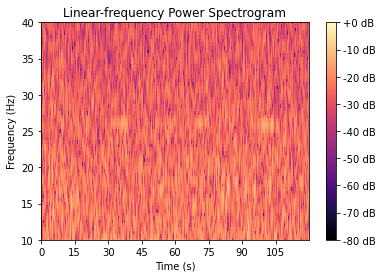

In [8]:
# Select a slice of the audio (seconds)
t_start = 0
t_end = 120

# Select y axis limits
ylim = [10, 40]

plot_spectrogram(y[sr*t_start:sr*t_end], ylim)

print(f'Frequency resolution {sr/N_FFT:.1f} Hz per bin')
print(f'Time resolution {1000*WIN_LENGTH/sr:.1f} ms\n')


### Plot wavelet scaleogram

Shannon wavelet
------------------------------
Center frequency: 0.800000011920929
Bandwidth frequency: 0.07000000029802322



C:\Users\james\anaconda3\envs\marine_acoustics\Lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


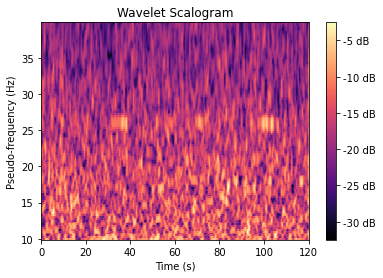

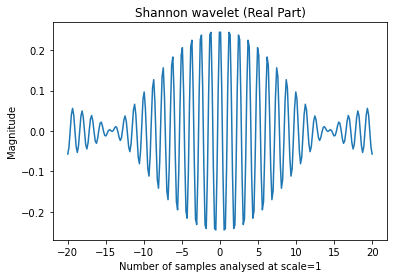

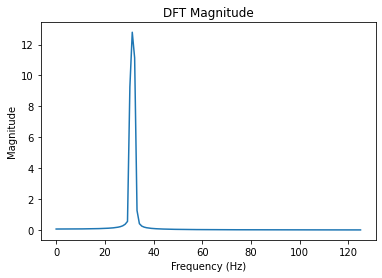

In [9]:
# Choose wavelet
#print(pywt.wavelist(kind='continuous'))
#wavelet = 'cmor25-2.0'    # wavelet type: complex morlet (bandwidth = 25 centre freq = 2.0)
wavelet = 'shan0.07-0.8'    # wavelet type: shannon (bandwidth = 0.07 centre freq = 0.8)


# Choose wavelet pseudo frequencies
desired_freqs = np.arange(ylim[0], ylim[1], 0.25)
scales = frequency2scale(wavelet, desired_freqs, sr)


# Plot
plot_cwt(y[sr*t_start:sr*t_end], sr, scales, wavelet)

# Plot wavelet
psi, x = plot_wavelet(wavelet)
plot_dft(psi, sr)
